In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.utils.extmath import softmax
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('../src')  # Go one level up and then into src
from SMF import SMF_BCD
from SMF_torch import smf

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [3]:
### Change the dimension of y for SMF_BCD
y_matrix = np.zeros((9, y.shape[0]))
for i in range(y.shape[0]):
    label = int(y[i])
    if label == 0:
        continue
    else:
        y_matrix[label-1, i] = 1

print(y_matrix.shape)

### Scale the input data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)

X= scaler.transform(X)

print(X.shape)

(9, 70000)
(70000, 784)


In [4]:
n_components = 16

SMF_Train = SMF_BCD([X.T, y_matrix], X_test=[X.T, y_matrix], xi= 5, n_components=n_components)

results_dict = SMF_Train.fit(iter=100, subsample_size=None,# search_radius_const=200*np.linalg.norm(X),
                                if_compute_recons_error=False, if_validate=False, threshold=0.5)

initial loading beta [[-0.46616483 -0.32667785 -0.94240319 -0.9287019   0.62392341 -0.72334954
   0.24235968 -0.33007572 -0.22619557 -0.98408032 -0.01431866  0.40958252
   0.02400206  0.71601444 -0.89877611 -0.6888325  -0.91752096]
 [-0.62304837 -0.18424004  0.55534039  0.67827529 -0.90591819 -0.25305524
   0.73353041  0.45265887  0.48665404 -0.48826635  0.36345517  0.91758281
   0.62851553 -0.90660184 -0.29806747  0.2652299   0.76354372]
 [-0.56038875 -0.23796105 -0.24800835 -0.75832445  0.2912364  -0.2783928
  -0.55216309 -0.16687807 -0.90749062  0.50253338 -0.51816846 -0.08446913
   0.43193925 -0.55913411  0.00845729 -0.70439231 -0.09384986]
 [-0.1737043   0.45032932 -0.96687436  0.96310638 -0.56078428  0.80135613
   0.47649675  0.18611629 -0.69067952 -0.74561904 -0.94159256  0.62002371
  -0.16787338 -0.12870472 -0.07102579 -0.28850096  0.0689282 ]
 [-0.48646393  0.36304509 -0.35857975 -0.20096725  0.3109631  -0.06839832
   0.22609977  0.40765175 -0.56874227  0.03242091 -0.63060097 

100%|██████████| 100/100 [06:11<00:00,  3.72s/it]
/Users/yee/miniforge3/envs/REU2024/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


!!! pred_type filter


In [5]:
W = results_dict.get('loading')[0]
beta= results_dict.get('loading')[1]
H = results_dict.get('code')

In [6]:
n = np.random.randint(0, 70000, size=100)
X_test = np.ones((X.shape[1], 100))
y_test = np.ones(shape=100)
for i in range(100):
    X_test[:, i] = X.T[:, n[i]]
    y_test[i] = y[n[i]]

p = np.zeros((100, 9))
for i in range(100):
    normalizer = 1 + np.sum(np.exp(beta[:, 1:] @ W.T @ X_test[:, i] + beta[:, 0]))
    p[i] = (np.exp(beta[:, 1:] @ W.T @ X_test[:, i] + beta[:, 0]) / normalizer).T


acc = 0
for j in range(100):
    prob = np.max(p[j])
    number = np.argmax(p[j]) + 1
    if (1 - np.sum(p[j])) > prob:
        number = 0
    if y_test[j] == number:
        acc += 1

print(f"The accuracy rate: {acc/100}")


The accuracy rate: 0.76


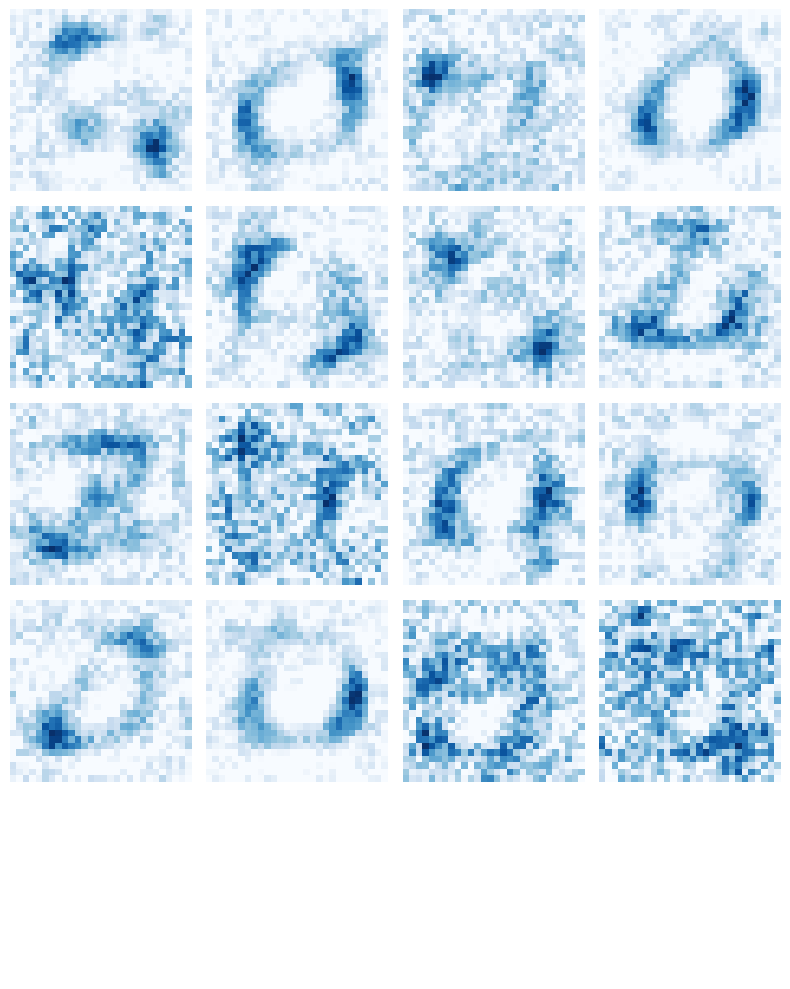

In [7]:
image = np.zeros((n_components, 28, 28))
for i in range(n_components):
    image[i] = W[:, i].reshape(28,28)

images_per_row = 4
n_rows = len(image) // images_per_row + 1

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=images_per_row, figsize=(images_per_row * 2, n_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < n_components:
        # Reshape and display each component as an image
        ax.imshow(image[i], cmap='Blues')  # Use gray scale color map
        ax.axis('off')  # Hide axes
    else:
        ax.axis('off')  # Hide axes for empty subplots

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("MINIST")

# Display the plot if needed
plt.show()

In [8]:
print(beta.T[0])

[-6.38214829 -0.16397689 -0.23544256  0.23706147  0.86429847 -0.64470989
 -2.85897924  1.15150717 -1.57425167]


# Torch Version

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.autograd import Variable

"""
#data = pd.read_csv('../Data/Pancreatic_GSE16515.csv')
data = pd.read_csv('../Data/Breast_GSE70947.csv')

print(data.shape)
y = data['type'].values
y = [1 if y[i] == 'breast_adenocarcinoma' else 0 for i in range(len(y))]
y = np.array(y)
X = data.drop(columns=['samples', 'type']).values
X = (X - np.mean(X, axis = 0))/(100*np.std(X, axis = 0)) # normalization
"""


hidden_size = 2

Accuracy = []
test_size = 0.5

X_train, X_test, Y_train, Y_test = train_test_split(X, y_matrix.T, test_size=test_size, random_state=2)
# print(X_train.shape)
# print(Y_train.shape)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(Y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(Y_test)).long()
# print(f"y_train's ndim: {y_train.ndim}")
# print(f"y_test: {y_test.shape}")

smf_model = smf(X_train, y_train, hidden_size, device='cuda')
smf_model.fit(num_epochs=10000,
               lr_classification=0.01,
               lr_matrix_factorization=0.01,
               xi=1,
               initialize='spectral',
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test, y_test],
               record_recons_error=True)
Accuracy.append(smf_model.test_multi(X_test, y_test))

--- Iteration -1: Training loss --- [Data, Label, Total] = [20611333.985233.3, 470100965.223118.3, 490712299.208351.3]
Epoch [10/10000],Loss_Classification: 1.6877 Loss_MF: 0.7806
mythre= 0.5
Test accuracy = 0.9280095238095238, Test confusion_mx = [[279904   3547]
 [ 19130  12419]]
Epoch [20/10000],Loss_Classification: 1.6877 Loss_MF: 0.7784
mythre= 0.5
Test accuracy = 0.9280095238095238, Test confusion_mx = [[279904   3547]
 [ 19130  12419]]
Epoch [30/10000],Loss_Classification: 1.6877 Loss_MF: 0.7784
mythre= 0.5
Test accuracy = 0.9280095238095238, Test confusion_mx = [[279904   3547]
 [ 19130  12419]]


KeyboardInterrupt: 